In [1]:
import sys
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import Image
from sklearn.decomposition import PCA
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.training import data_split_augment, train_model
from src.model import *
from src.visualization import *
from main import load_newest_model
from src.loader import load_and_preprocess_image

In [2]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
input_tensor = Input(shape=(224, 224, 3))
x = base_model(input_tensor)
x = GlobalAveragePooling2D()(x)  # Add global average pooling
feature_extractor = Model(inputs=input_tensor, outputs=x)
base_model.trainable = False

In [3]:
dummy_input = np.random.random((1, 224, 224, 3)).astype("float32")
try:
    dummy_output = feature_extractor.predict(dummy_input)
    print(f"Feature extractor output shape: {dummy_output.shape}") 
except Exception as e:
    print(f"Error during feature extraction: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
Feature extractor output shape: (1, 1280)


In [4]:
print(feature_extractor.input_shape)
print(feature_extractor.output_shape)

(None, 224, 224, 3)
(None, 1280)


In [5]:
# Define the base directory for raw images
data_dir = os.path.join(project_root, "data", "raw")
data_dir

'c:\\Users\\antho\\Coding\\repos\\fruit-classifier\\data\\raw'

In [6]:
image_paths = []
labels = []
class_labels = sorted(os.listdir(data_dir))  
class_to_index = {label: idx for idx, label in enumerate(class_labels)}  
for class_label in class_labels:
    class_dir = os.path.join(data_dir, class_label)
    if not os.path.isdir(class_dir):
        continue  

    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
            image_paths.append(image_path)
            labels.append(class_to_index[class_label])

# Display some results
print(f"Total images: {len(image_paths)}")
print(f"Example image path: {image_paths[0]}")
print(f"Example label: {labels[0]} ({class_labels[labels[0]]})")

Total images: 359
Example image path: c:\Users\antho\Coding\repos\fruit-classifier\data\raw\apple fruit\Image_1.jpg
Example label: 0 (apple fruit)


In [7]:
features = []

for image_path in image_paths:
    try:
        preprocessed_image = load_and_preprocess_image(image_path)

        feature = feature_extractor.predict(preprocessed_image)
        print(feature[0])
        features.append(feature[0])
    except Exception as  e:
        print(f"Error processing {image_path}: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.28593296 0.12457433 0.         ... 0.01002106 0.37520093 0.        ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[1.1193004  0.         0.17388803 ... 0.         0.85423183 0.        ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.11919397 0.         0.64900064 ... 0.         1.2397305  0.        ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.11560656 0.04250296 0.00224584 ... 0.0325049  0.43709925 0.        ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.02033489 0.8196528  0.         ... 0.         1.4789791  0.        ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[1.1482456  0.4737048  0.01664411 ... 0.         0.35088426 0.05141808]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[1.4504502e+00 1.1260753e-03 2.6660639e-01 ... 1.4590925e-03 5.5531847e-01
 0.0000000e+00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.66209257 0.16860525 0.         ... 0.14230365 0.45791283 0.5996895 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[1.6852227 0.        0.        ... 0.        1.5423619 0.      

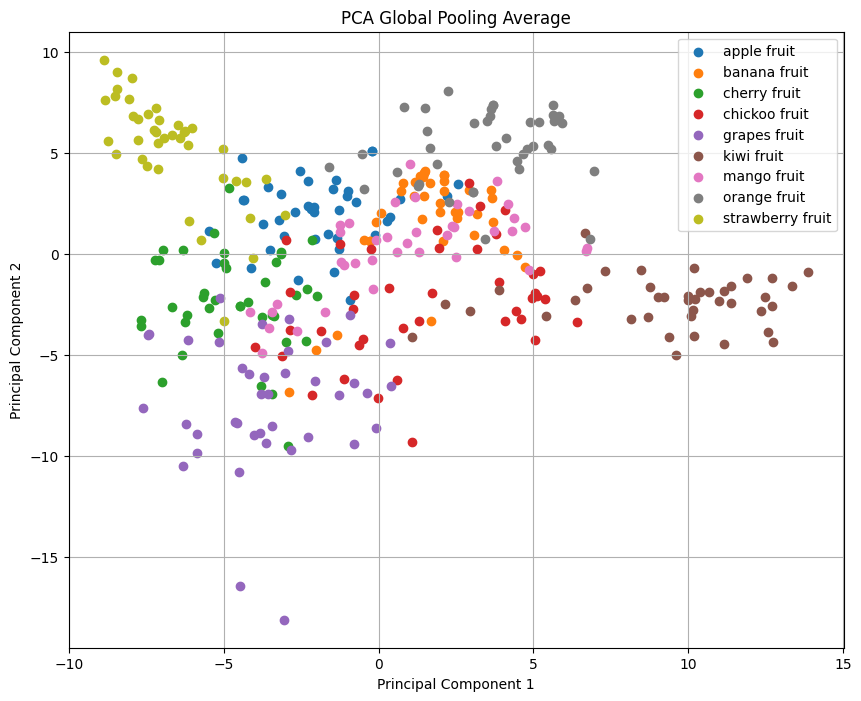

In [8]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features) 

class_labels = ['apple fruit', 'banana fruit', 'cherry fruit', 'chickoo fruit', 'grapes fruit', 
                'kiwi fruit', 'mango fruit', 'orange fruit', 'strawberry fruit']

plt.figure(figsize=(10, 8))
for class_label in np.unique(labels):
    idx = np.array(labels) == class_label
    plt.scatter(features_pca[idx, 0], features_pca[idx, 1], label=class_labels[class_label])

plt.title("PCA Global Pooling Average")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()


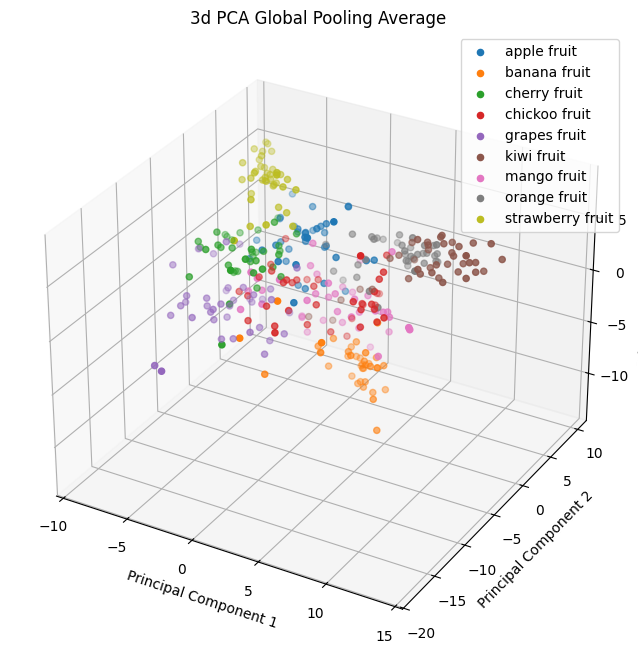

In [9]:
pca3d = PCA(n_components=3)
features_pca3d = pca3d.fit_transform(features)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for class_label in np.unique(labels):
    idx = np.array(labels) == class_label
    ax.scatter(features_pca3d[idx, 0], features_pca3d[idx, 1], features_pca3d[idx, 2], label=class_labels[class_label])

# Add labels and legend
ax.set_title("3d PCA Global Pooling Average")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.legend()
plt.show()